# Demo: Building Denoising Autoencoders in Pytorch (CIFAR10)

By: Jacob Cybulski<br>
Date: July 2023<br>
Comment: *Lots of bugs fixed, works with Torch 2, on both CPU and GPU*

Sources: 
<ol>
<li>Eugenia Anello, Denoising Autoencoder in Pytorch on MNIST dataset, Dataseries (Medium), Jun 28, 2021.</li>
<li>Eugenia Anello, <a href="https://github.com/eugeniaring/Medium-Articles/blob/main/Pytorch/denAE.ipynb">GitHub</a>, Jun 28, 2021.</li>
<li>Phillip Lippe, Tutorial 9: Deep Autoencoders, UvA Deep Learning Tutorials, Fall 2022.</li>
</ol>

In [1]:
!pip list | grep torch

torch                         2.0.1+cu118
torchaudio                    2.0.2+cu118
torchsummary                  1.5.1
torchvision                   0.15.2+cu118


In [2]:
import matplotlib.pyplot as plt
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


## Prelims: Get data and create tensor data loaders

In [4]:
data_dir = 'dataset'
train_dataset = torchvision.datasets.CIFAR10(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.CIFAR10(data_dir, train=False, download=True)

print('Training data shape:', train_dataset.data.shape)
print('Test data shape:', test_dataset.data.shape, '\n')

Files already downloaded and verified
Files already downloaded and verified
Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3) 



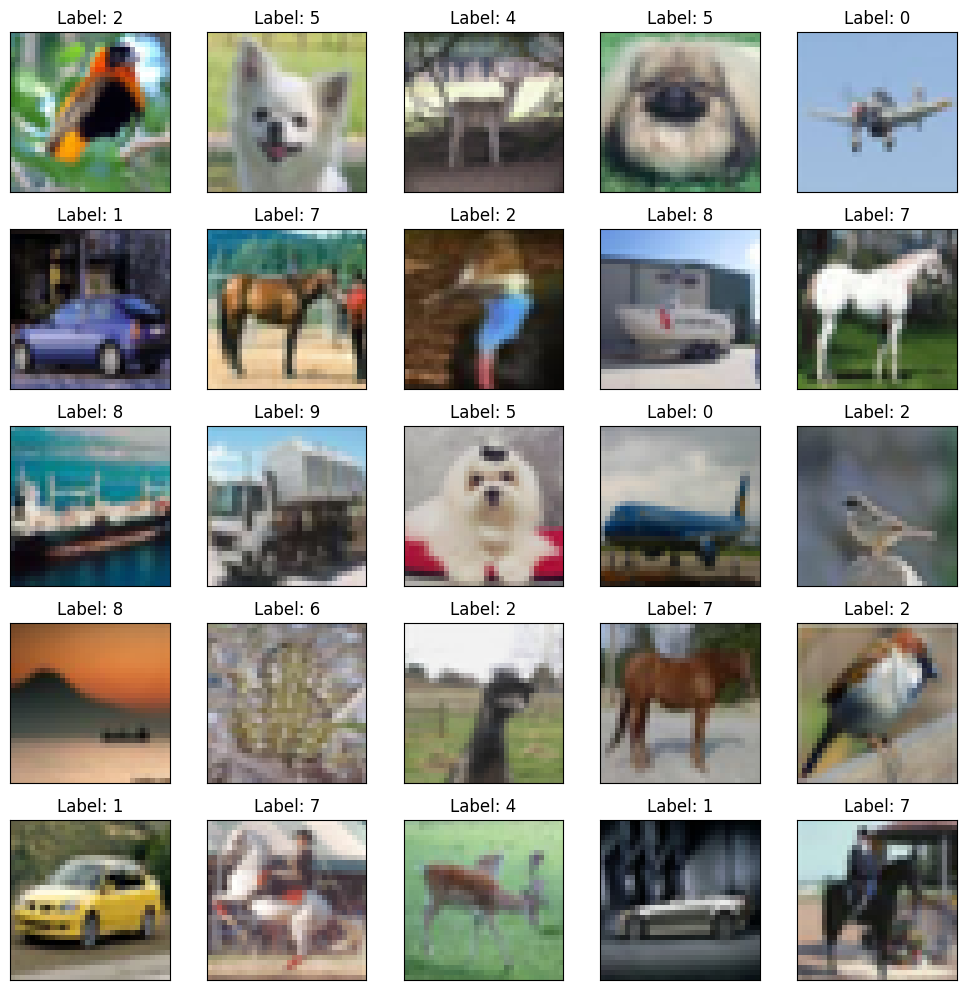

In [5]:
fig, axs = plt.subplots(5, 5, figsize=(10,10))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img))
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [6]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform

# Set the test transform
test_dataset.transform = test_transform

In [7]:
m=len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

## 1 Define Encoder and Decoder classes

In [8]:
test_dataset.data.shape

(10000, 32, 32, 3)

In [9]:
# Images are (N, W, H)
B = batch_size                 # Batch size
N = test_dataset.data.shape[0] # Examples
W = test_dataset.data.shape[1] # Width
H = test_dataset.data.shape[2] # Height
C = test_dataset.data.shape[3] # Channels
BC = W                         # Base channels
D = W * H * C                  # Features
classes = 10                   # Label classes

# Input of shape (C, W)

# Filters of shape (C, K)
kernels = 12                   # Number of kernels
K = 3                          # Size of kernels
d = 384                        # Latent dimension

In [10]:
class Encoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*16*c_hid, latent_dim)
        )
    
    def forward(self, x):
        return self.net(x)

In [11]:
class Decoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*16*c_hid),
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )
    
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

## 2 initialize models, loss and optimizer
*Note that "d" is the size of a latent space*

In [12]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
# encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
encoder = Encoder(C, BC, d)
decoder = Decoder(C, BC, d)
encoder.to(device)
decoder.to(device)
print('Encoder and decoder created')

Encoder and decoder created


In [13]:
summary(encoder, (C, W, H))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             896
              GELU-2           [-1, 32, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           9,248
              GELU-4           [-1, 32, 16, 16]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
              GELU-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          36,928
              GELU-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 4, 4]          36,928
             GELU-10             [-1, 64, 4, 4]               0
          Flatten-11                 [-1, 1024]               0
           Linear-12                  [-1, 384]         393,600
Total params: 496,096
Trainable params: 496,096
Non-trainable params: 0
-------------------------------

In [14]:
summary(decoder, (1, d))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1024]         394,240
              GELU-2              [-1, 1, 1024]               0
   ConvTranspose2d-3             [-1, 64, 8, 8]          36,928
              GELU-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,928
              GELU-6             [-1, 64, 8, 8]               0
   ConvTranspose2d-7           [-1, 32, 16, 16]          18,464
              GELU-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 32, 16, 16]           9,248
             GELU-10           [-1, 32, 16, 16]               0
  ConvTranspose2d-11            [-1, 3, 32, 32]             867
             Tanh-12            [-1, 3, 32, 32]               0
Total params: 496,675
Trainable params: 496,675
Non-trainable params: 0
-------------------------------

In [15]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001 # Learning rate


params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr)

## 3 Train model

In [16]:
im = test_dataset[0][0].unsqueeze(0)
a = im + torch.randn_like(im)*0.3
print(a)

tensor([[[[ 0.9101,  0.2978,  0.9226,  ...,  0.6656,  0.4053,  0.6687],
          [ 0.3458,  0.2692,  0.4134,  ...,  0.7271,  0.3748,  0.3986],
          [ 0.9596,  0.8324,  0.7510,  ...,  0.7792,  0.4098,  0.6299],
          ...,
          [ 0.3208, -0.0119,  0.2856,  ..., -0.1928, -0.3957, -0.1004],
          [ 0.4540,  0.0508, -0.2779,  ...,  0.3446,  0.0812,  0.4567],
          [ 0.1230,  0.4325,  0.4407,  ...,  0.0746,  0.1445,  0.3927]],

         [[ 0.3675, -0.0284,  0.6404,  ...,  0.6949,  0.5407,  0.4667],
          [ 0.5573,  0.6035,  0.2413,  ...,  0.2977,  0.8181,  0.0930],
          [ 0.9161,  0.5568,  0.5692,  ...,  0.5323,  0.8934,  0.5695],
          ...,
          [ 0.2071,  0.5840,  0.0280,  ...,  0.5473,  0.8136,  0.3995],
          [ 0.5835,  0.3507,  0.0743,  ...,  0.3618,  0.5193,  0.3334],
          [ 0.7702,  0.4339,  0.7135,  ...,  0.1227,  0.0862,  0.4484]],

         [[-0.5292,  0.1366,  0.1362,  ...,  0.2759, -0.0322, -0.0270],
          [ 0.5585, -0.0893, -

In [17]:
b = torch.clip(a,0.,1.)
print(b)

tensor([[[[0.9101, 0.2978, 0.9226,  ..., 0.6656, 0.4053, 0.6687],
          [0.3458, 0.2692, 0.4134,  ..., 0.7271, 0.3748, 0.3986],
          [0.9596, 0.8324, 0.7510,  ..., 0.7792, 0.4098, 0.6299],
          ...,
          [0.3208, 0.0000, 0.2856,  ..., 0.0000, 0.0000, 0.0000],
          [0.4540, 0.0508, 0.0000,  ..., 0.3446, 0.0812, 0.4567],
          [0.1230, 0.4325, 0.4407,  ..., 0.0746, 0.1445, 0.3927]],

         [[0.3675, 0.0000, 0.6404,  ..., 0.6949, 0.5407, 0.4667],
          [0.5573, 0.6035, 0.2413,  ..., 0.2977, 0.8181, 0.0930],
          [0.9161, 0.5568, 0.5692,  ..., 0.5323, 0.8934, 0.5695],
          ...,
          [0.2071, 0.5840, 0.0280,  ..., 0.5473, 0.8136, 0.3995],
          [0.5835, 0.3507, 0.0743,  ..., 0.3618, 0.5193, 0.3334],
          [0.7702, 0.4339, 0.7135,  ..., 0.1227, 0.0862, 0.4484]],

         [[0.0000, 0.1366, 0.1362,  ..., 0.2759, 0.0000, 0.0000],
          [0.5585, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0864],
          [0.3406, 0.0000, 0.2778,  ..., 0

In [18]:
def add_noise(inputs,noise_factor=0.3):
     noise = inputs+torch.randn_like(inputs)*noise_factor
     noise = torch.clip(noise,0.,1.)
     return noise

In [19]:
### Training function
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer, noise_factor=0.3):
    
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader:
        
        # Move tensor to the proper device
        image_noisy = add_noise(image_batch,noise_factor)
        image_noisy = image_noisy.to(device)    
        
        # Encode data
        encoded_data = encoder(image_noisy)
        
        # Decode data
        decoded_data = decoder(encoded_data)
        
        # Evaluate loss
        loss = loss_fn(decoded_data, image_noisy)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [20]:
### Testing function
def test_epoch_den(encoder, decoder, device, dataloader, loss_fn,noise_factor=0.3):
    
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad(): # No need to track the gradients
        
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        
        for image_batch, _ in dataloader:
            
            # Move tensor to the proper device
            image_noisy = add_noise(image_batch,noise_factor)
            image_noisy = image_noisy.to(device)
            
            # Encode data
            encoded_data = encoder(image_noisy)
            
            # Decode data
            decoded_data = decoder(encoded_data)
            
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
            
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
        
    return val_loss.data

**Note that image axes must have been incorrectly assigned in the process of its encoding and decoding, the correction was applied in image plotting**

In [21]:
def plot_ae_outputs_den(encoder,decoder,n=5,noise_factor=0.3):
    plt.figure(figsize=(10,4.5))
    for i in range(n):

        ax = plt.subplot(3,n,i+1)
        img = test_dataset[i][0].unsqueeze(0)
        image_noisy = add_noise(img,noise_factor)     
        image_noisy = image_noisy.to(device)

        encoder.eval()
        decoder.eval()

        with torch.no_grad():
            rec_img  = decoder(encoder(image_noisy))

        img_sel = img.cpu().squeeze().numpy()
        img_sel = img_sel.swapaxes(0,1)
        img_sel = img_sel.swapaxes(1,2)
        plt.imshow(img_sel, cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
            
        ax = plt.subplot(3, n, i + 1 + n)
        img_sel = image_noisy.cpu().squeeze().numpy()
        img_sel = img_sel.swapaxes(0,1)
        img_sel = img_sel.swapaxes(1,2)
        plt.imshow(img_sel, cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Corrupted images')

        ax = plt.subplot(3, n, i + 1 + n + n)
        img_sel = rec_img.cpu().squeeze().numpy()
        img_sel = img_sel.swapaxes(0,1)
        img_sel = img_sel.swapaxes(1,2)
        plt.imshow(img_sel, cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
            
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()   



 EPOCH 1/50 	 train loss 0.129 	 val loss 0.042


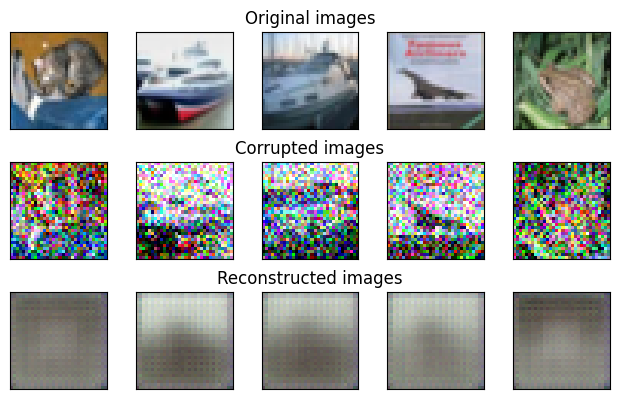



 EPOCH 2/50 	 train loss 0.085 	 val loss 0.029


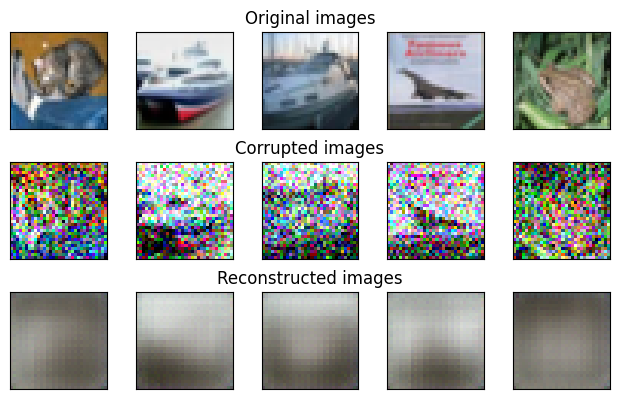



 EPOCH 3/50 	 train loss 0.079 	 val loss 0.025


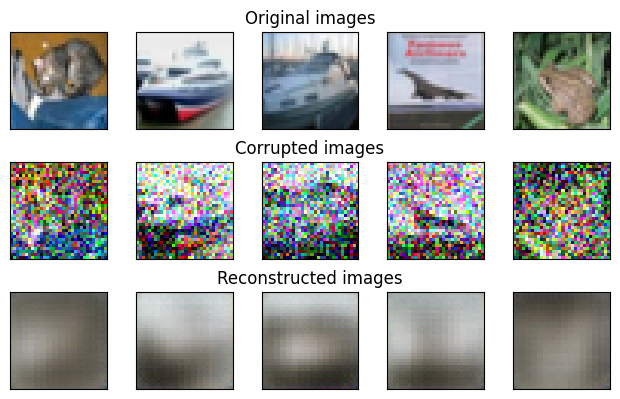



 EPOCH 4/50 	 train loss 0.077 	 val loss 0.022


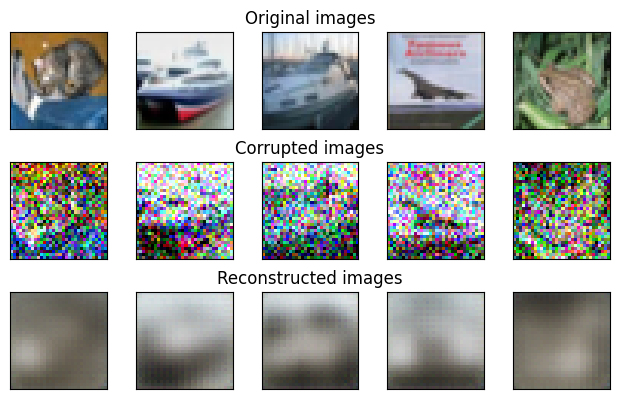



 EPOCH 5/50 	 train loss 0.075 	 val loss 0.020


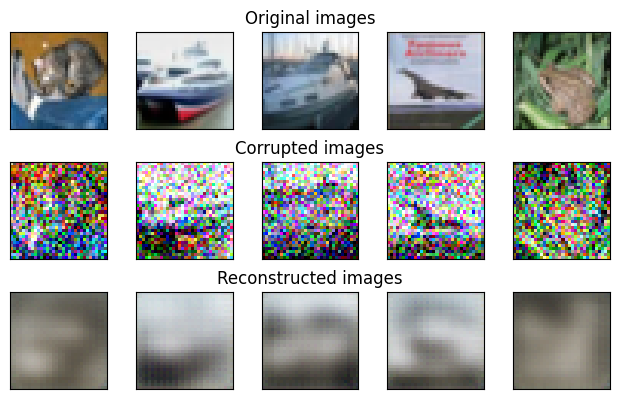



 EPOCH 6/50 	 train loss 0.074 	 val loss 0.019


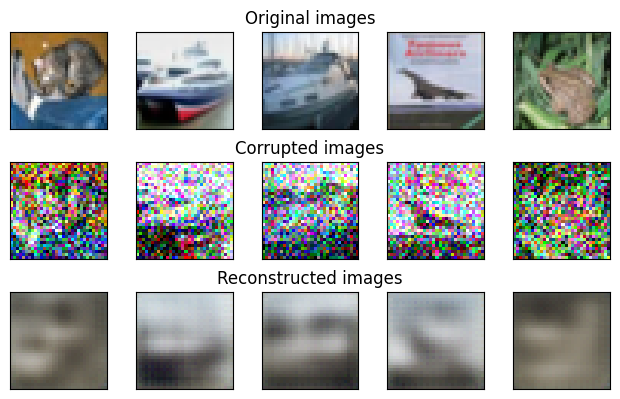



 EPOCH 7/50 	 train loss 0.073 	 val loss 0.018


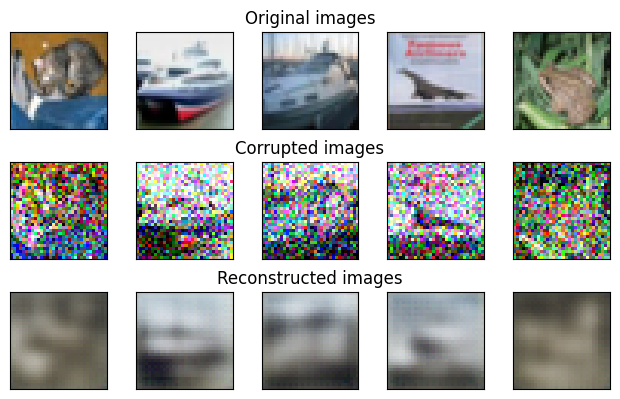



 EPOCH 8/50 	 train loss 0.074 	 val loss 0.018


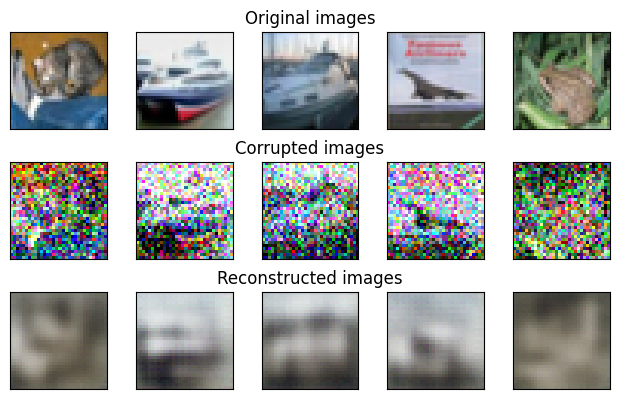



 EPOCH 9/50 	 train loss 0.071 	 val loss 0.015


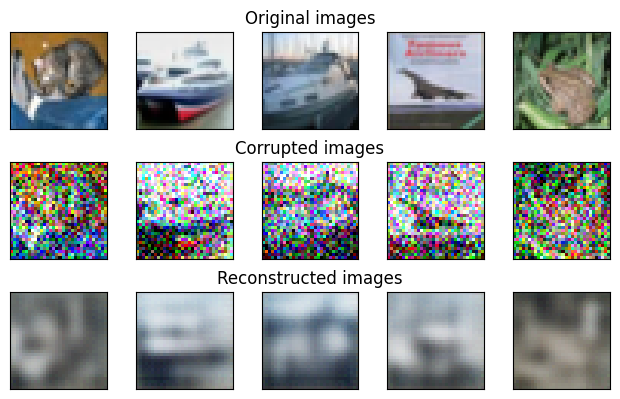



 EPOCH 10/50 	 train loss 0.070 	 val loss 0.014


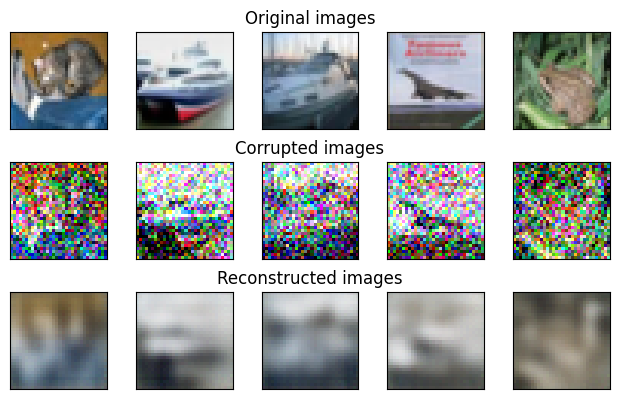



 EPOCH 11/50 	 train loss 0.069 	 val loss 0.014


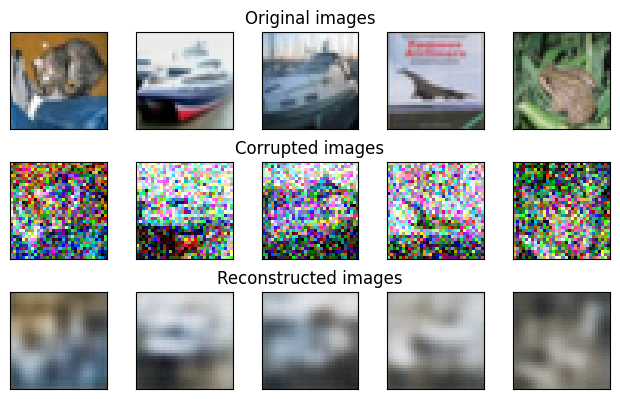



 EPOCH 12/50 	 train loss 0.069 	 val loss 0.014


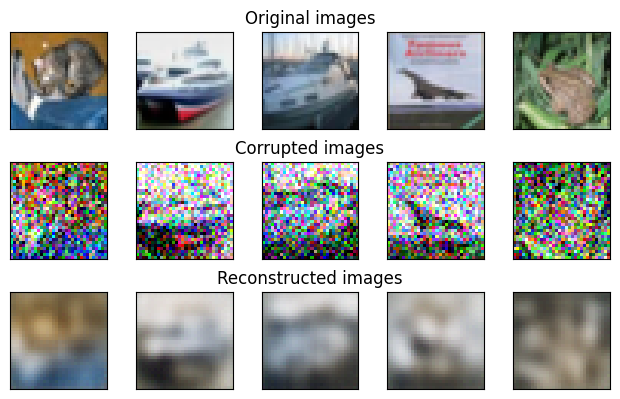



 EPOCH 13/50 	 train loss 0.068 	 val loss 0.013


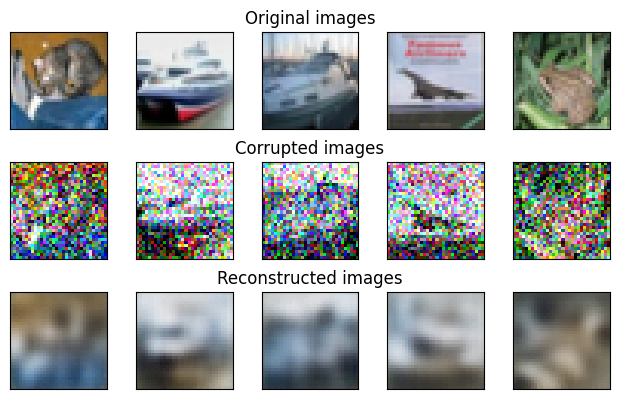



 EPOCH 14/50 	 train loss 0.068 	 val loss 0.013


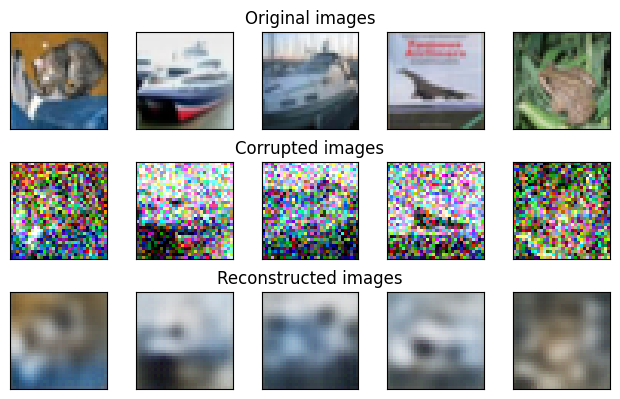



 EPOCH 15/50 	 train loss 0.068 	 val loss 0.014


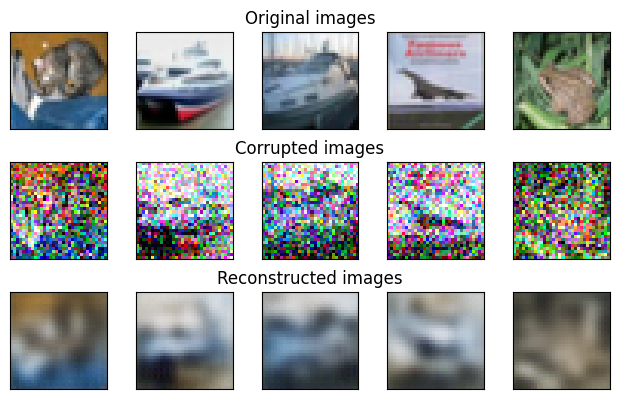



 EPOCH 16/50 	 train loss 0.068 	 val loss 0.013


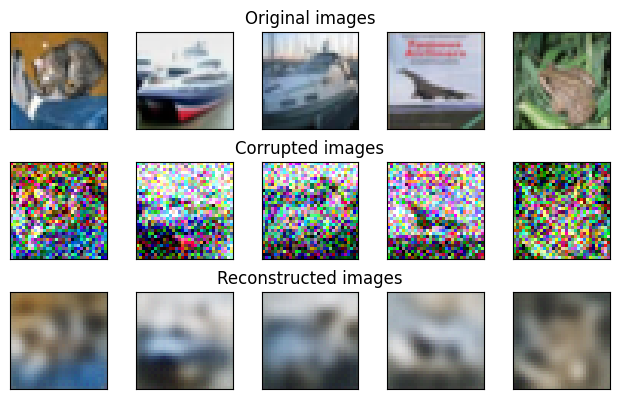



 EPOCH 17/50 	 train loss 0.068 	 val loss 0.013


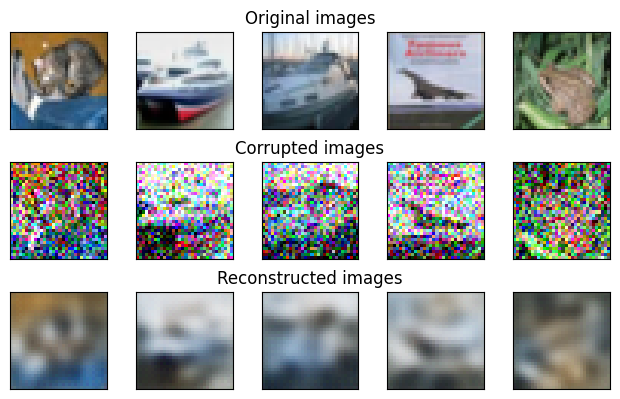



 EPOCH 18/50 	 train loss 0.067 	 val loss 0.012


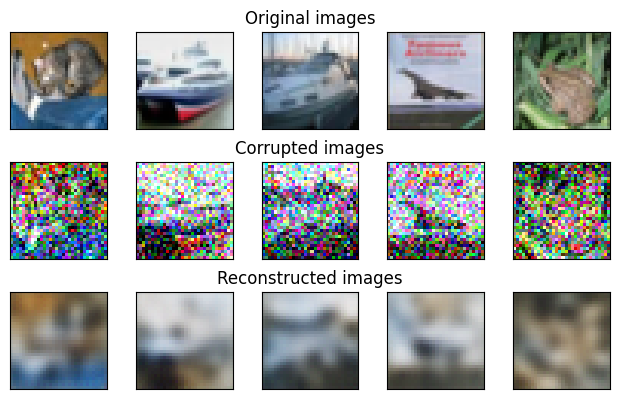



 EPOCH 19/50 	 train loss 0.067 	 val loss 0.013


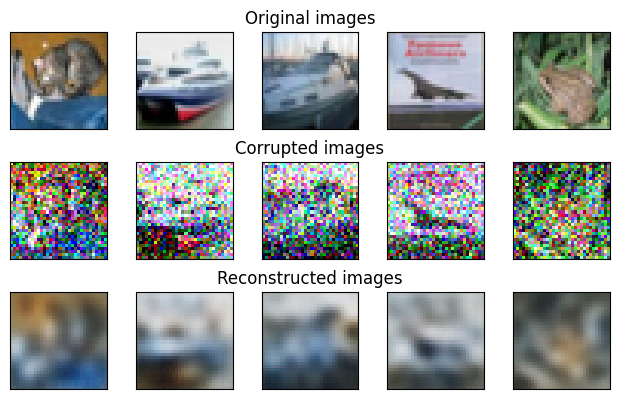



 EPOCH 20/50 	 train loss 0.067 	 val loss 0.012


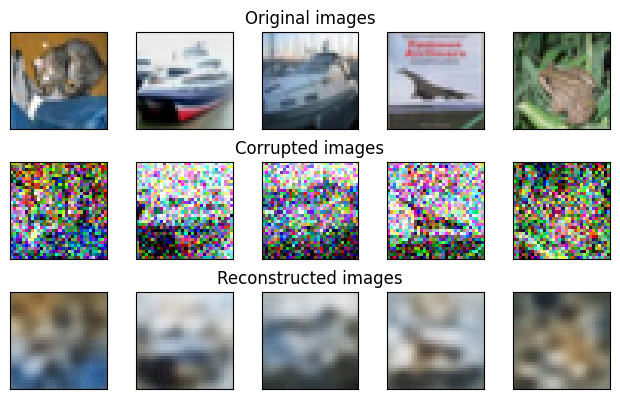



 EPOCH 21/50 	 train loss 0.067 	 val loss 0.012


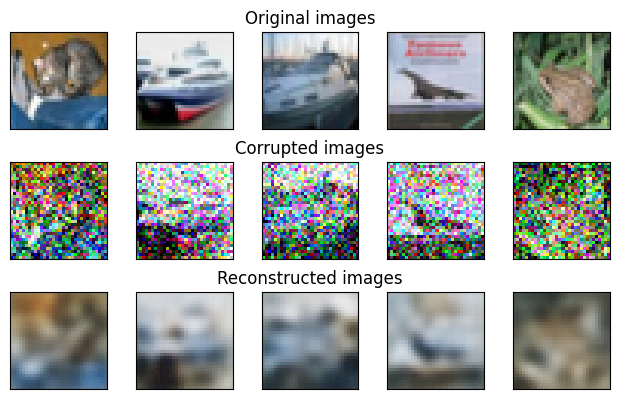



 EPOCH 22/50 	 train loss 0.066 	 val loss 0.012


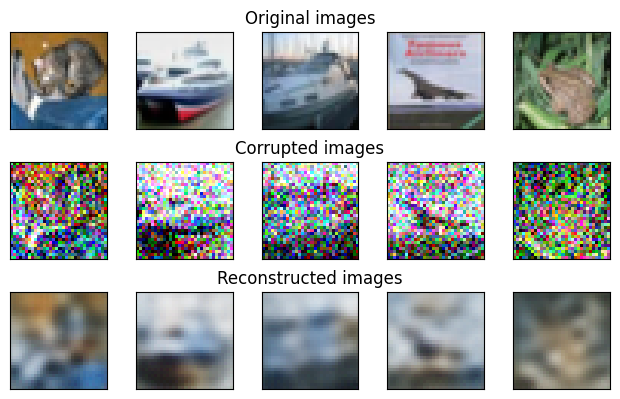



 EPOCH 23/50 	 train loss 0.066 	 val loss 0.012


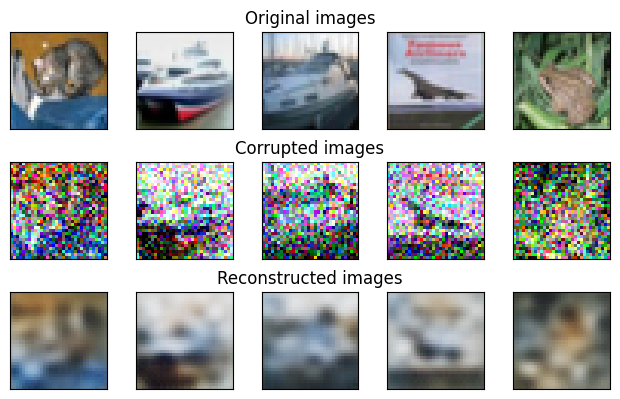



 EPOCH 24/50 	 train loss 0.066 	 val loss 0.011


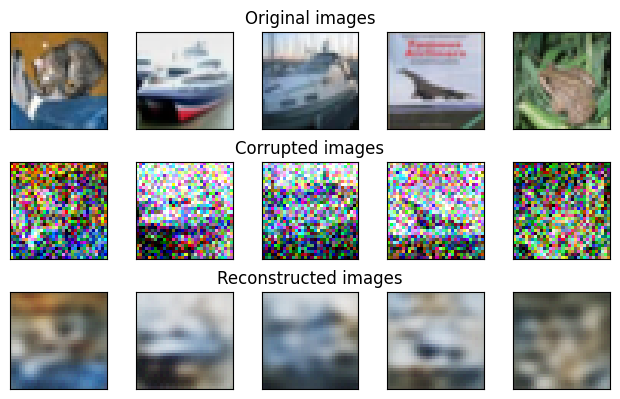



 EPOCH 25/50 	 train loss 0.066 	 val loss 0.011


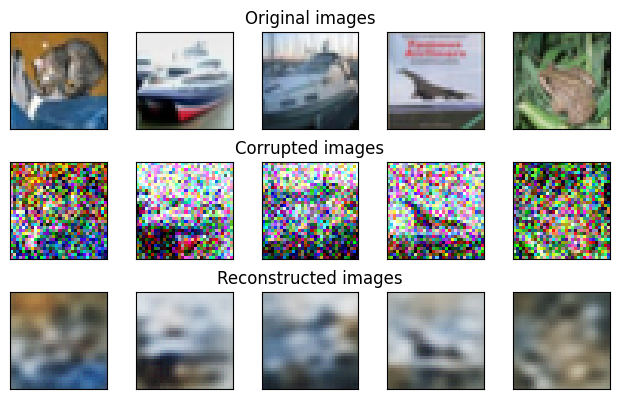



 EPOCH 26/50 	 train loss 0.066 	 val loss 0.013


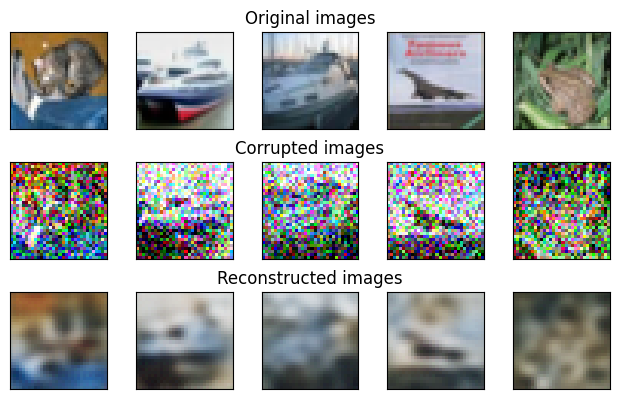



 EPOCH 27/50 	 train loss 0.065 	 val loss 0.011


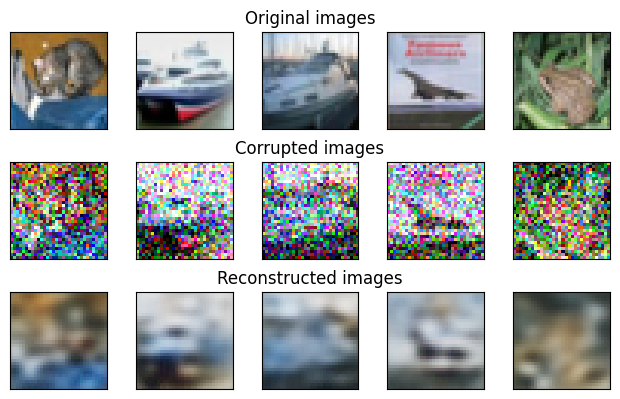



 EPOCH 28/50 	 train loss 0.065 	 val loss 0.011


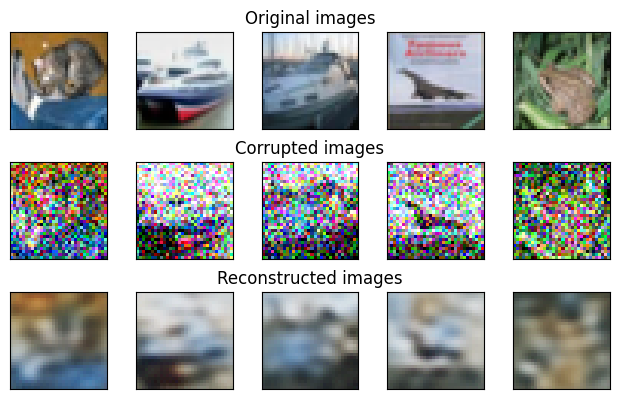



 EPOCH 29/50 	 train loss 0.065 	 val loss 0.011


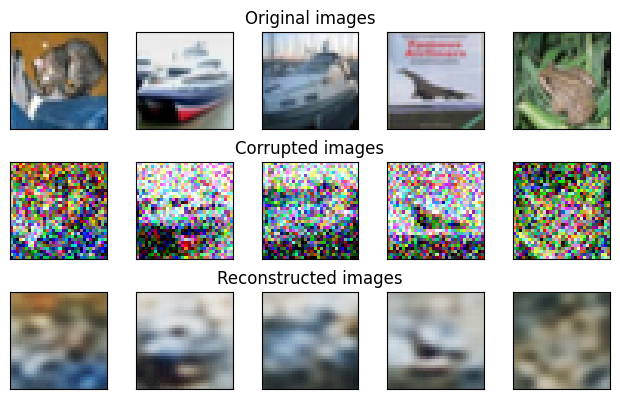



 EPOCH 30/50 	 train loss 0.065 	 val loss 0.011


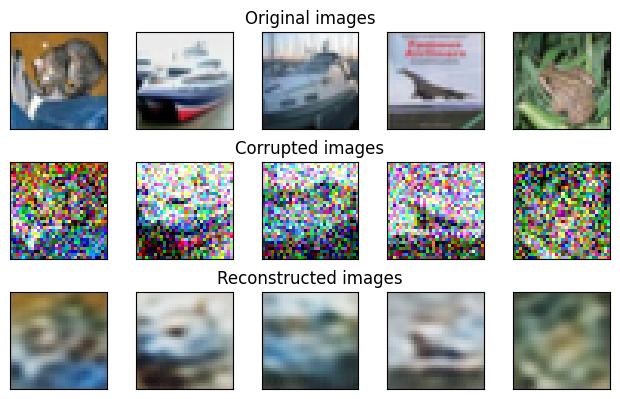



 EPOCH 31/50 	 train loss 0.065 	 val loss 0.011


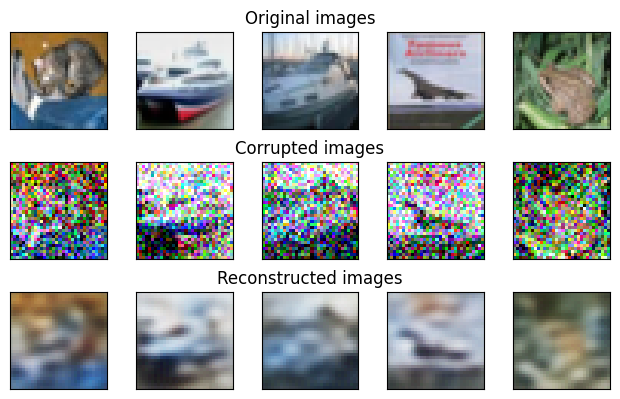



 EPOCH 32/50 	 train loss 0.064 	 val loss 0.011


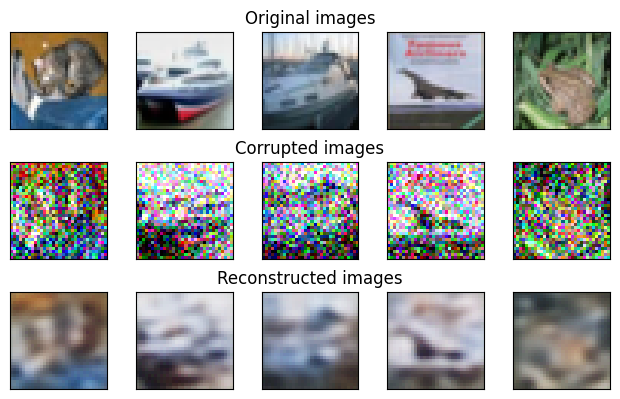



 EPOCH 33/50 	 train loss 0.064 	 val loss 0.010


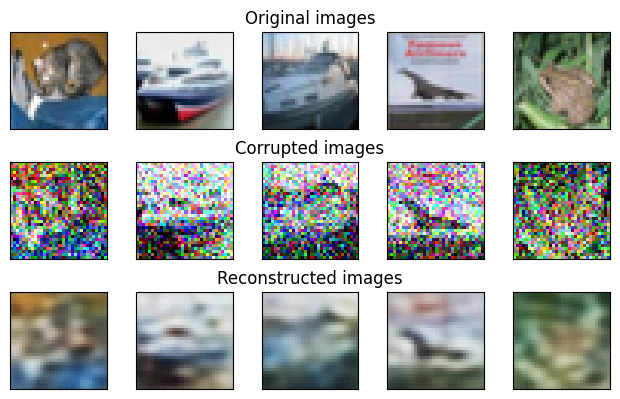



 EPOCH 34/50 	 train loss 0.064 	 val loss 0.010


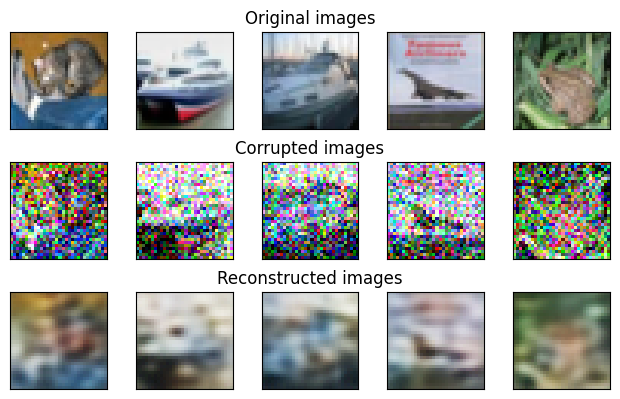



 EPOCH 35/50 	 train loss 0.064 	 val loss 0.010


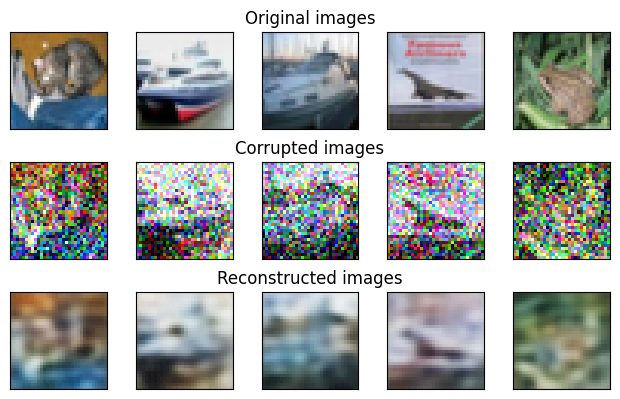



 EPOCH 36/50 	 train loss 0.063 	 val loss 0.010


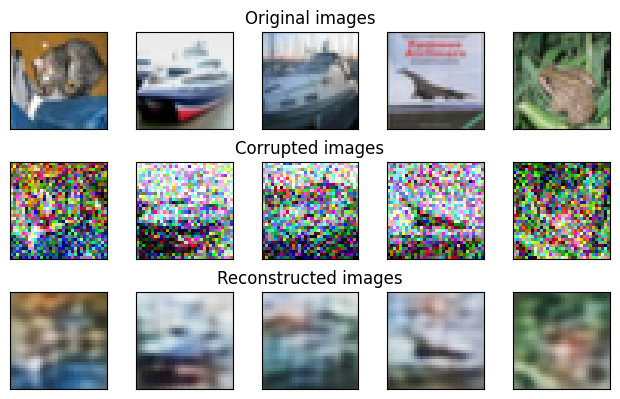



 EPOCH 37/50 	 train loss 0.063 	 val loss 0.010


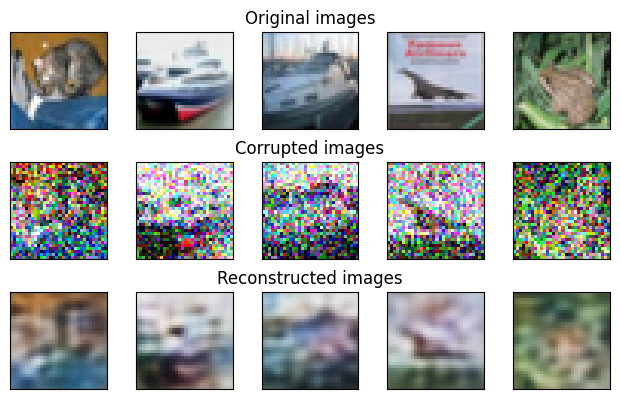



 EPOCH 38/50 	 train loss 0.063 	 val loss 0.010


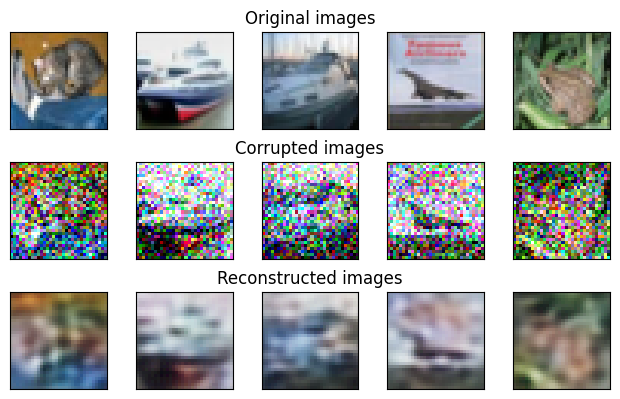



 EPOCH 39/50 	 train loss 0.063 	 val loss 0.010


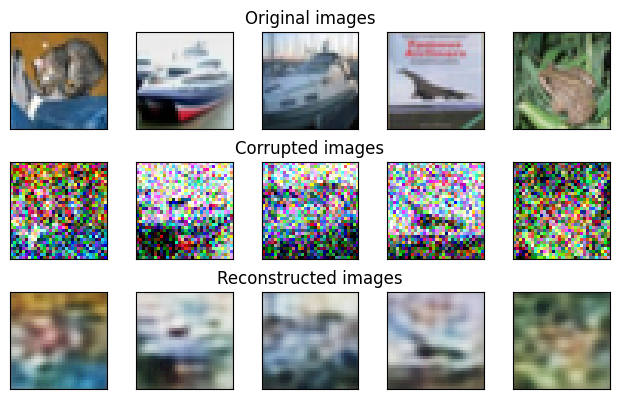



 EPOCH 40/50 	 train loss 0.062 	 val loss 0.010


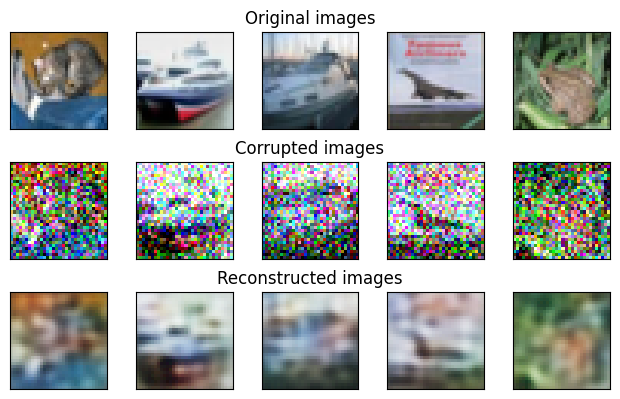



 EPOCH 41/50 	 train loss 0.062 	 val loss 0.010


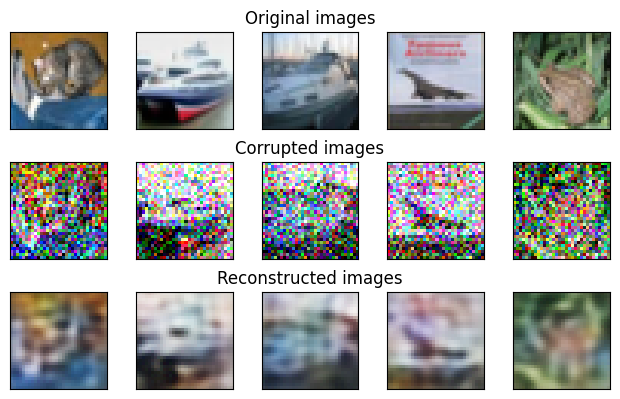



 EPOCH 42/50 	 train loss 0.062 	 val loss 0.010


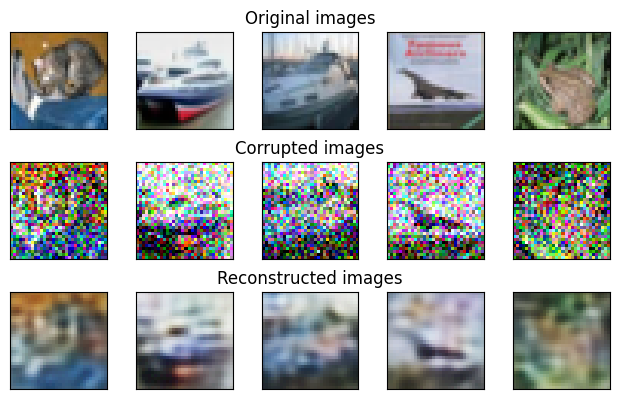



 EPOCH 43/50 	 train loss 0.062 	 val loss 0.010


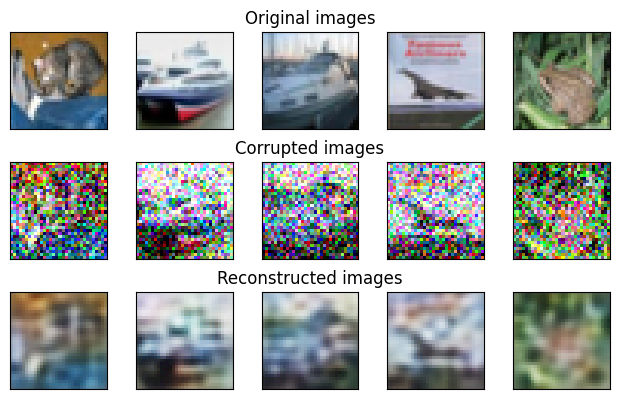



 EPOCH 44/50 	 train loss 0.062 	 val loss 0.010


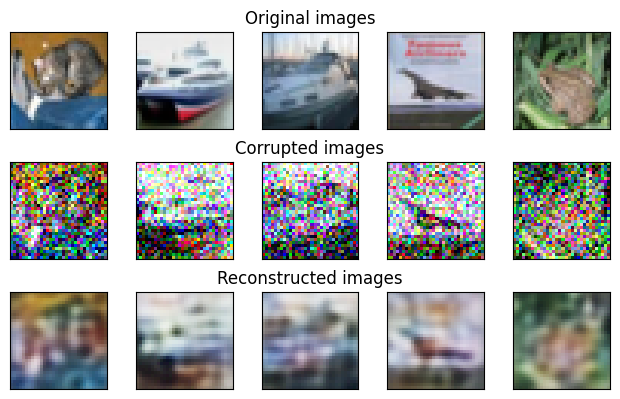



 EPOCH 45/50 	 train loss 0.062 	 val loss 0.010


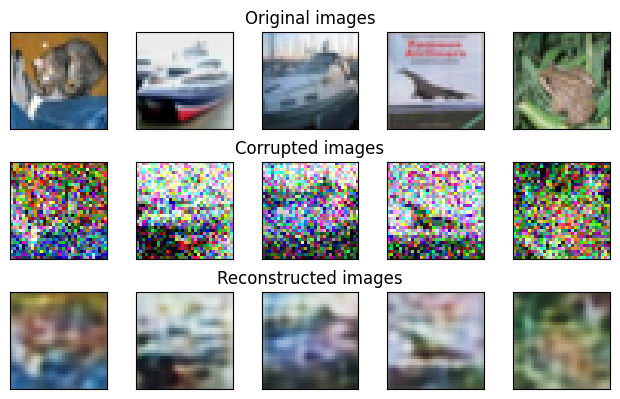



 EPOCH 46/50 	 train loss 0.062 	 val loss 0.010


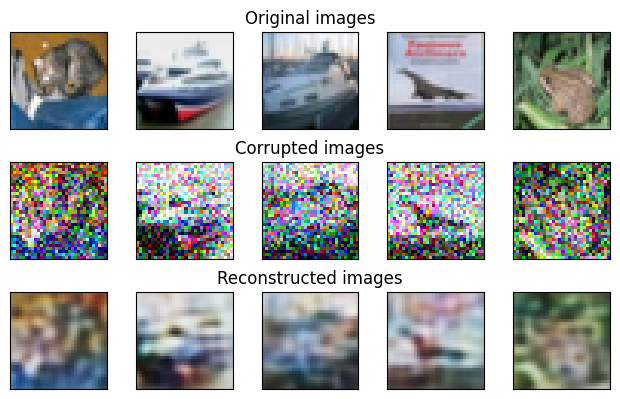



 EPOCH 47/50 	 train loss 0.062 	 val loss 0.010


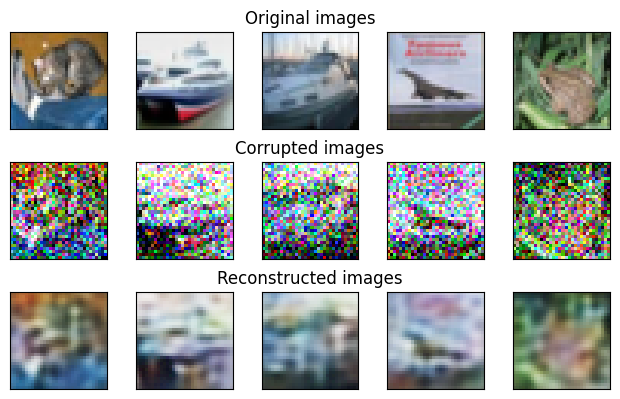



 EPOCH 48/50 	 train loss 0.061 	 val loss 0.010


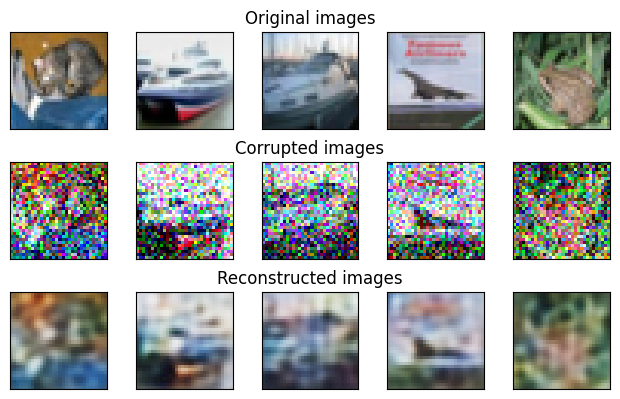



 EPOCH 49/50 	 train loss 0.061 	 val loss 0.010


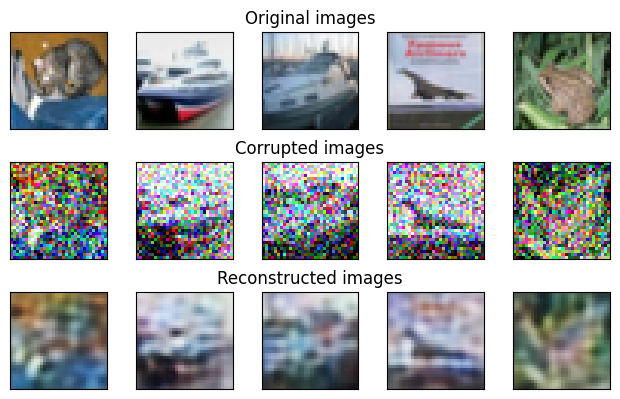



 EPOCH 50/50 	 train loss 0.061 	 val loss 0.011


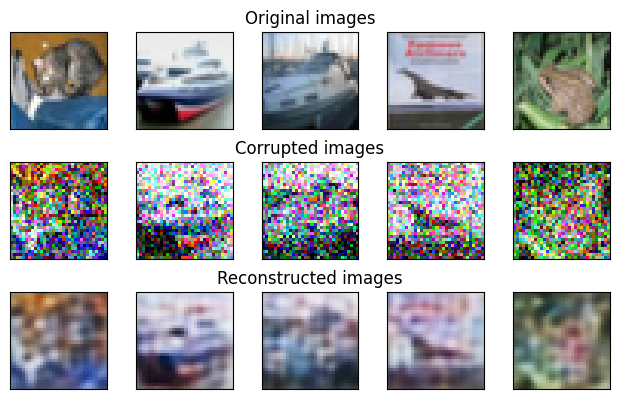



CPU times: user 16min 24s, sys: 12.9 s, total: 16min 37s
Wall time: 5min 59s


In [22]:
%%time

### Training cycle
noise_factor = 0.3
num_epochs = 40
history_da={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    # print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    
    ### Training (use the training function)
    train_loss=train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_loader, 
        loss_fn=loss_fn, 
        optimizer=optim,noise_factor=noise_factor)
    
    ### Validation  (use the testing function)
    val_loss = test_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=valid_loader, 
        loss_fn=loss_fn,noise_factor=noise_factor)
    
    # Print Validationloss
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print('\n\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs_den(encoder,decoder,noise_factor=noise_factor)

print('\n')

**Final set of images**

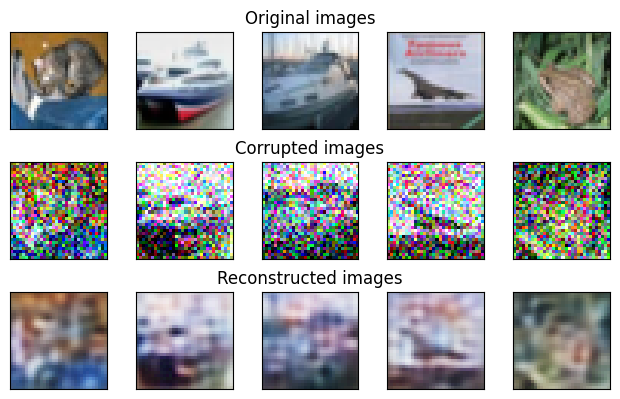

In [23]:
plot_ae_outputs_den(encoder,decoder,noise_factor=noise_factor)

**<br>Note that validation loss seems unusually lower than training loss!**<br><br>
*The reason is that training loss is the average of progressive losses calculated for every image in the batch,<br>
whereas validation loss is calculated at the end of the batch training, when the model performs much better.*

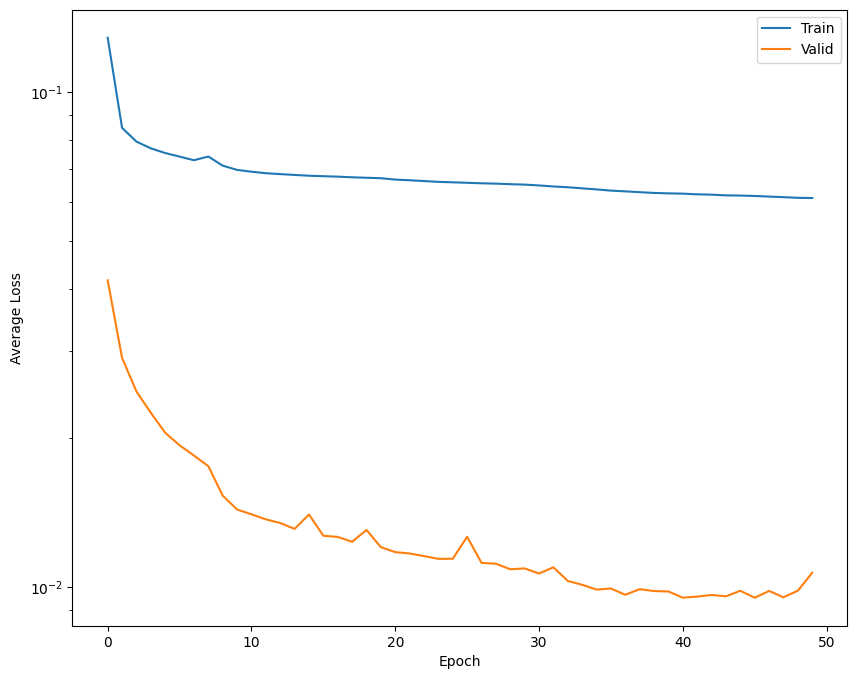

In [24]:
# Plot training performance
test_epoch_den(encoder,decoder,device,test_loader,loss_fn).item()# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(history_da['train_loss'], label='Train')
plt.semilogy(history_da['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

## 4 Visualize latent space

100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1532.22it/s]


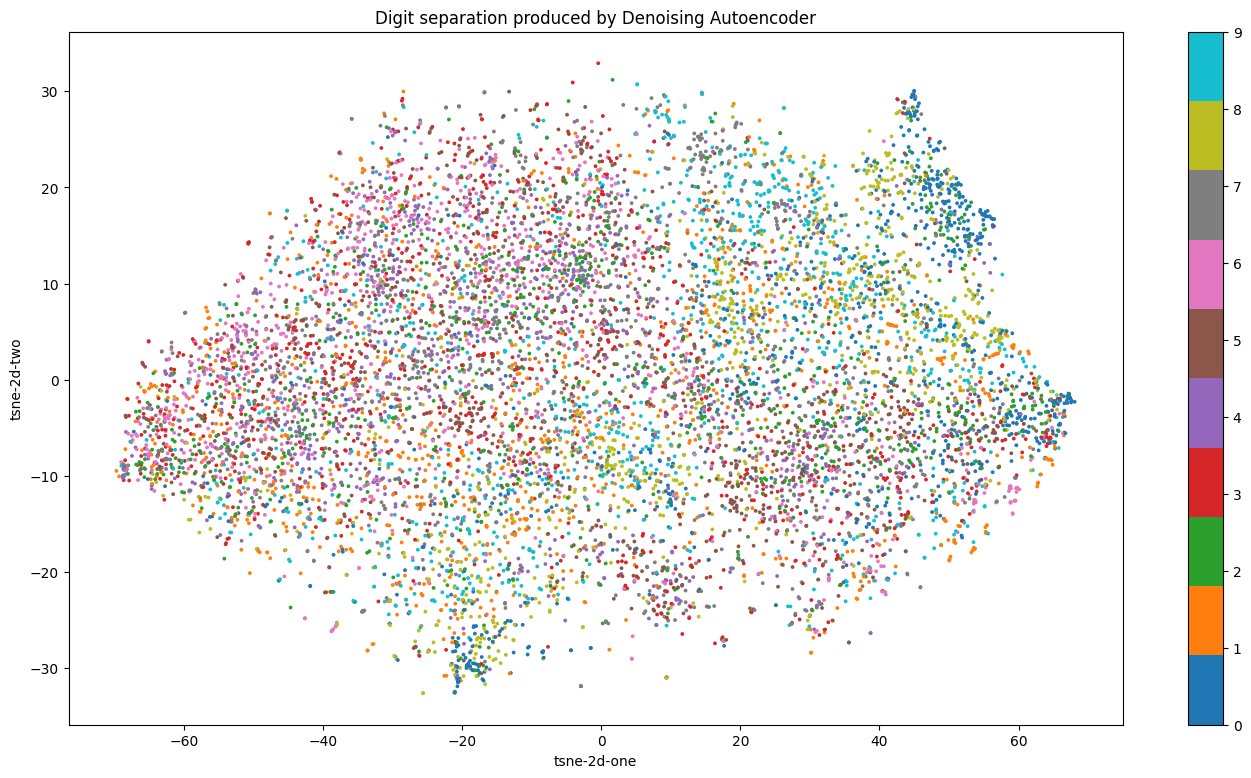

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


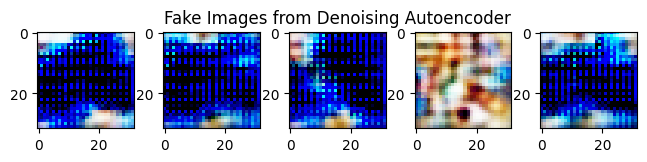

In [25]:
def plot_results(encoder, decoder, data, rx=(-5, 5), ry=(-5, 5), model_name='VAE'):

    # Encode all data samples
    encoded_samples = []
    for sample in tqdm(data):
        
        # Separate image data from its label 
        img = sample[0].unsqueeze(0).to(device)
        label = sample[1]
        
        # Encode image
        encoder.eval()
        with torch.no_grad():
            encoded_img  = encoder(img)
        
        # Append to list
        encoded_img = encoded_img.flatten().cpu().numpy()
        encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
        encoded_sample['label'] = label
        encoded_samples.append(encoded_sample)
        
        # Find latend dimension from decoded image
        latent_dim = len(encoded_img)
        
    encoded_samples = pd.DataFrame(encoded_samples)

    # Create a TSNE model and plot it
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
    
    plt.figure(figsize=(17, 9))
    plt.scatter(tsne_results[:,0], tsne_results[:,1], c=encoded_samples.label, cmap='tab10', s=3)
    plt.xlabel('tsne-2d-one')
    plt.ylabel('tsne-2d-two')
    plt.title(f'Digit separation produced by {model_name}')
    plt.colorbar()
    plt.show()
    
def plot_fakes(encoder, decoder, n, rx=(-5, 5), ry=(-5, 5), model_name='VAE'):

    channels = 3
    latent_dim = d
    digit_size = 32
    
    plt.figure(figsize=(10,4.5))
    for i in range(n):

        coords = [int(v*10) for v in np.random.rand(latent_dim)]
        # print(f'Vector from latent space: {coords}')
        z = torch.Tensor([coords]).to(device)
        x_hat = decoder(z)
        img = x_hat.reshape(channels, digit_size, digit_size).to('cpu').detach().numpy()

        ax = plt.subplot(3, n, i + 1 + n + n)
        img = img.swapaxes(0,1)
        img = img.swapaxes(1,2)
        plt.imshow(img)  

        if i == n//2:
            ax.set_title(f'{model_name}')
            
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()   
    
plot_results(encoder, decoder, test_dataset, rx=(-1, 1), ry=(-1, 1), model_name="Denoising Autoencoder")
plot_fakes(encoder, decoder, n=5, rx=(-1, 1), ry=(-1, 1), model_name="Fake Images from Denoising Autoencoder")

In [26]:
import qiskit.tools.jupyter
%qiskit_version_table